# Consumer Electronics Sales Forecasting
## Forecasting Sales for Fast Moving Consumer Electronics to Optimize Inventory Management and Maximize Profitability

### Import packages

In [49]:
import random
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

### Data Collection

The dataset will be brought into the Python environment with Pandas.

In [50]:
df = pd.read_csv('Dataset.csv')

See a subset of the dataset - the first few rows, to see how the data looks like.

In [51]:
df.head()

,Product_ID,Category,Price,Date,Season,Market_Trend_Index,Competitor_Activity_Score,Consumer_Confidence_Index,Product_Specification_1,Product_Specification_2,Sales_Volume
0,1103,Laptop,105.32,2009-01-01,Winter,-1.859160,0.546694,84.680465,Spec_C,Long-Battery-Life,49
1,1436,Tablet,145.55,2009-01-01,Winter,-0.345587,0.940428,42.919288,Spec_C,Lightweight,69
2,1271,Smartphone,97.82,2009-01-01,Winter,-0.384738,0.751155,55.191268,Spec_B,Lightweight,50
3,1107,Laptop,64.00,2009-01-01,Winter,0.716763,0.125939,88.746454,Spec_B,High-Resolution,28
4,1072,Tablet,67.83,2009-01-01,Winter,-0.242074,-0.412932,67.947536,Spec_A,Long-Battery-Life,81


A quick overview of what each column represents to note from this:
- `Product_ID`: This is the ID that distinguishes the products from each other. It contains integer values.
- `Category`: This is the product category, from what can be seen here, there are Laptop, Tablet and Smartphone categories among other.
- `Price`: This is the price of the product in US dollars.
- `Date`: The date of the sale of that product.
- `Season`: The season of the year that product was sold.
- `Market_Trend_Index`: Represents external factors affecting the electronic industry.
- `Competitor_Activity_Score`: Measure the influence of the company's competitors in the market.
- `Consumer_Confidence_Index`: Measures consumer confidence at that particular date.
- Product Specifications: Specific information on the the products themselves.

### Data Preprocessing

In the Data Preprocessing step:
- missing values will be handled, to avoid unintended errors when handling the dataset later,
- removing duplicates in the dataset if they exists, in order to prevent skewed results and incorrect conclusions,
- the `Date` column will be converted to a datetime format, so that the data can be grouped weekly or monthly with the `Date` column if there is a need for grouping.

Check for missing values and handle them if there are.

In [52]:
missing_values = df.isnull().sum()

missing_values

Product_ID                   0
Category                     0
Price                        0
Date                         0
Season                       0
Market_Trend_Index           0
Competitor_Activity_Score    0
Consumer_Confidence_Index    0
Product_Specification_1      0
Product_Specification_2      0
Sales_Volume                 0
dtype: int64

Since the values of each of the `missing_values` table shown above are all `0`, there are no missing values in the dataset.

Check for duplicates in the dataset and remove them if there are.

In [53]:
df.duplicated().any()

False

Since the result is `False`, it shows that there are no duplicate rows in the dataset.

Convert the `Date` column to datetime format, so that the data can be grouped weekly or monthly with the `Date` column if there is a need for grouping.

In [54]:
df['Date'] = pd.to_datetime(df['Date'])

### Exploratory Data Analysis (EDA)

With EDA, the sales trends over time will be visualized for product category in the database, in order to identify:
- patterns,
- seasonality.

Group the dataset by `Date` and `Category` and sum the `Sales_Volume` and store this is in `sales_by_date_category`. So that only the total sales volume per day, of each product category is captured in `sales_by_date_category`.

In [55]:
sales_by_date_category = df.groupby(['Date', 'Category']).sum()['Sales_Volume'].reset_index()

sales_by_date_category.head(10)

,Date,Category,Sales_Volume
0,2009-01-01,Accessories,619
1,2009-01-01,Laptop,790
2,2009-01-01,Smartphone,564
3,2009-01-01,Tablet,768
4,2009-01-02,Accessories,227
5,2009-01-02,Laptop,210
6,2009-01-02,Smartphone,99
7,2009-01-02,Tablet,419
8,2009-01-03,Accessories,230
9,2009-01-03,Laptop,31


As seen in the `sales_by_date_category` DataFrame, the data has been grouped into daily sales volume for each category.

Plot sales trends for each product category in the dataset.

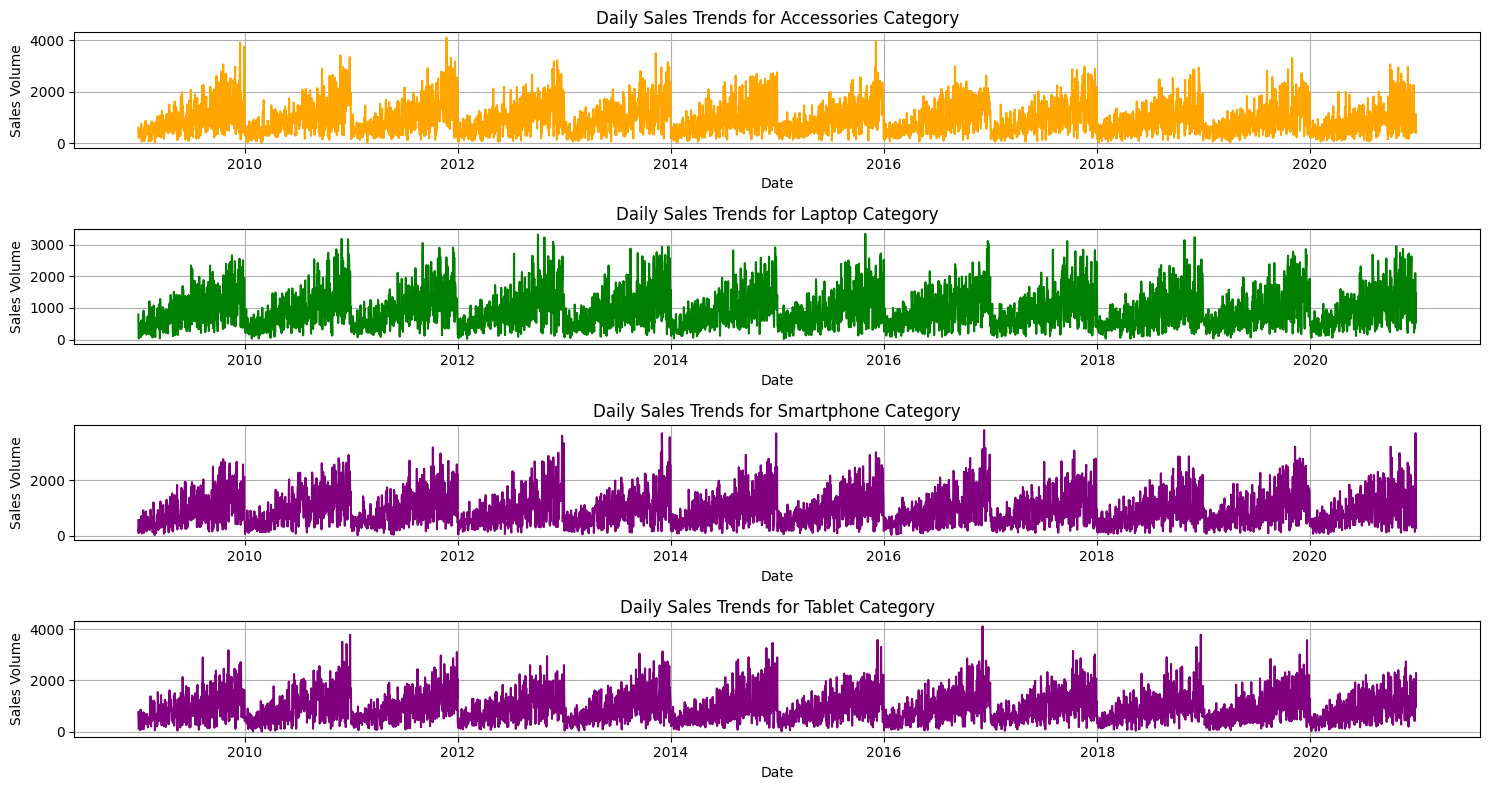

In [56]:
# Get all unique categories from the dataset
all_categories = sales_by_date_category['Category'].unique()

# Number of categories in the dataset
n_categories = len(all_categories)

# Begin plotting
plt.figure(figsize=(15, 8))

plotting_colors = ['blue', 'green', 'red', 'purple', 'orange']

for i in range(n_categories):

    # Get a subset of the data for a particular category.
    category = all_categories[i]
    subset = sales_by_date_category[sales_by_date_category['Category'] == category]

    plt.subplot(n_categories, 1, i+1)

    # Plot the subset.
    plt.plot(subset['Date'], subset['Sales_Volume'], color=random.choice(plotting_colors))
    plt.title(f'Daily Sales Trends for {category} Category')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.grid(True)

plt.tight_layout()
plt.show()

From the visualization above, a few speculations can be made:
- there are flunctuations in the sales volume for each of the product categories over time.
- there seems to be some recurring pattern, which may indicate some seasonality in sales.
- for the Smartphone, Tablet and Laptop categories, there seem to be some usual spike in the sales volume towards the end of the year.

In order to better understand these speculations, we will make a monthly plot of the sales volume for each category. We will begin by grouping the `sales_by_date_category` data into months, and storing this in `sales_by_month_category`.

In [57]:
# Make a copy of the `sales_by_date_category`, we don't want to
# edit it.
sales_by_month_category = sales_by_date_category.copy()

# Change the `Date` column to monthly dates
sales_by_month_category['Date'] = sales_by_month_category['Date'].dt.to_period('M')

# Take the sum of the Sales Volume for each product category per month.
sales_by_month_category = sales_by_month_category.groupby(['Date', 'Category']).sum()['Sales_Volume'].reset_index()

# Convert the Date column back to a timestamp so that it can be plotted later on.
sales_by_month_category['Date'] = sales_by_month_category['Date'].dt.to_timestamp()

# Change th
sales_by_month_category.head(10)

,Date,Category,Sales_Volume
0,2009-01-01,Accessories,11762
1,2009-01-01,Laptop,11989
2,2009-01-01,Smartphone,12192
3,2009-01-01,Tablet,12491
4,2009-02-01,Accessories,12086
5,2009-02-01,Laptop,14507
6,2009-02-01,Smartphone,13563
7,2009-02-01,Tablet,16043
8,2009-03-01,Accessories,18578
9,2009-03-01,Laptop,20525


As seen above, the Sales Volume for each product category has been grouped into months.

We then plot the Sales Volume per month for each product category to see how it trends/flunctuates with time.

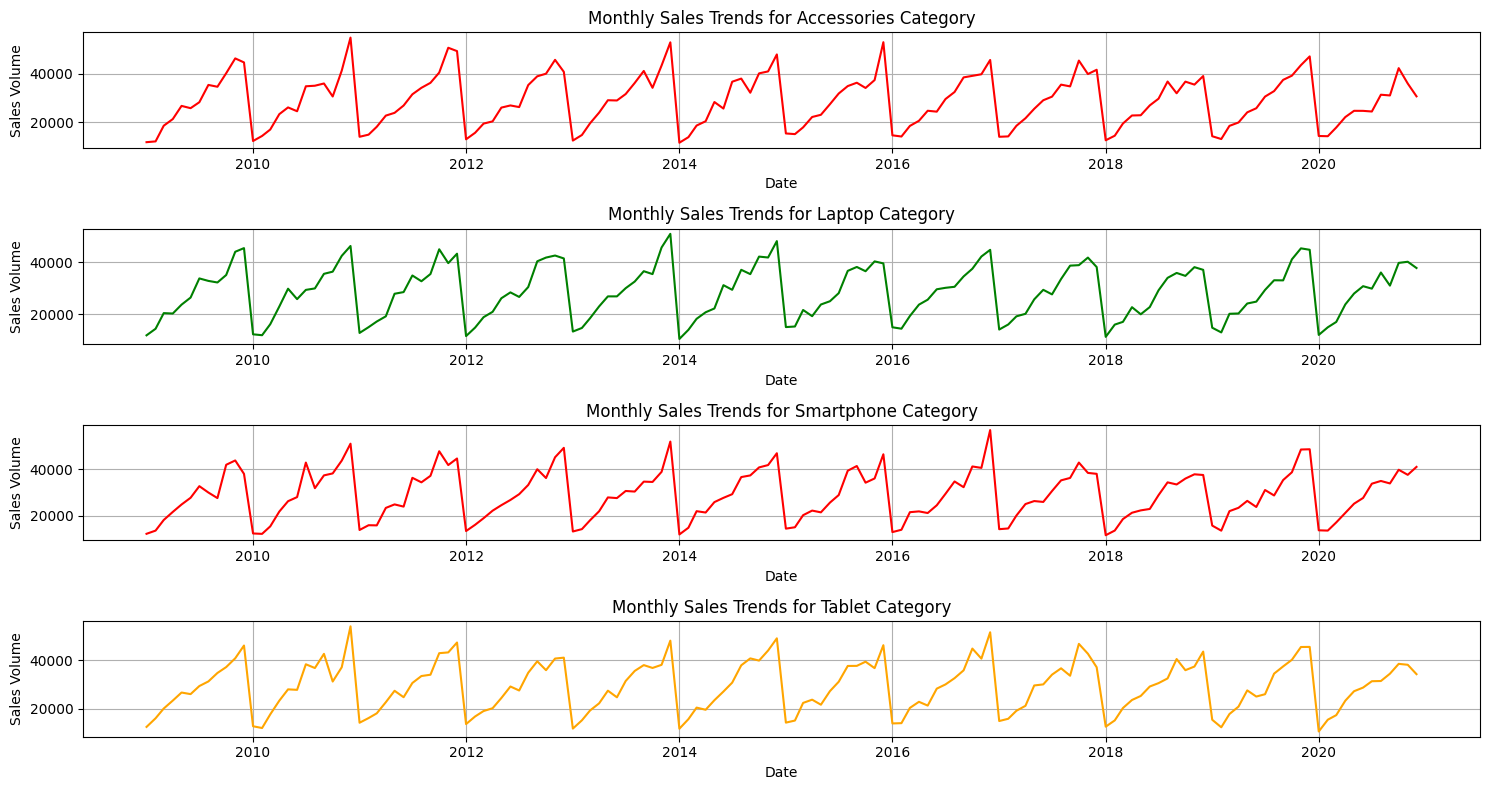

In [58]:
# Get all unique categories from the dataset
all_categories = sales_by_month_category['Category'].unique()

# Number of categories in the dataset
n_categories = len(all_categories)

# Begin plotting
plt.figure(figsize=(15, 8))

plotting_colors = ['blue', 'green', 'red', 'purple', 'orange']

for i in range(n_categories):

    # Get a subset of the data for a particular category.
    category = all_categories[i]
    subset = sales_by_month_category[sales_by_month_category['Category'] == category]

    plt.subplot(n_categories, 1, i+1)

    # Plot the subset.
    plt.plot(subset['Date'], subset['Sales_Volume'], color=random.choice(plotting_colors))
    plt.title(f'Monthly Sales Trends for {category} Category')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.grid(True)

plt.tight_layout()
plt.show()

From the visualization above, it is now clear that:
- there is a yearly seasonality in sales trends with time over the year.
- for each category, there seem to be some usual spike in the sales volume towards the end of the year.

### Forecasting

Time series forecasting methods, such as ARIMA or Prophet, will be used to predict future sales for each category of product.

Different methods of forecasting will be used here, they include:
- Prophet forecasting model,
- ARIMA forecasting model,
- Holt-Winters (Exponential Smoothing).

#### Forecasting weekly with Prophet model

We will begin by forecasting for each of the product categories. We're starting with weekly forecasting because:
- daily forecasting introduces a lot of short term flunctuations that may be difficult to control,
- with weekly forecasts, we can easily aggregate sales for a short period of time and forecast easily, 
- the flunctuations in the sales volume will have been summed up into bigger values easing our model training process.

The `sales_by_date_category` dataset which contains the daily sales per category, will be grouped into weeks for each product category.

In [59]:
# Copy the `sales_by_date_category` data
sales_by_week_category = sales_by_date_category.copy()

# Set the Date column as the index
sales_by_week_category = sales_by_week_category.set_index('Date')

# Group the dataset by weeks and category, the Date Column becomes an index
sales_by_week_category = sales_by_week_category.groupby([pd.Grouper(freq='W-MON'), 'Category']).sum()

# Group the Date column back
sales_by_week_category = sales_by_week_category.reset_index()

sales_by_week_category.head(10)

,Date,Category,Sales_Volume
0,2009-01-05,Accessories,1933
1,2009-01-05,Laptop,1868
2,2009-01-05,Smartphone,1488
3,2009-01-05,Tablet,2283
4,2009-01-12,Accessories,2912
5,2009-01-12,Laptop,2273
6,2009-01-12,Smartphone,2959
7,2009-01-12,Tablet,2736
8,2009-01-19,Accessories,1459
9,2009-01-19,Laptop,3060


As can be seen, the dates now only increase by seven days for each product category.

The dataset will be filtered for each category, split into train and test set, and then fitted on separate models for each category. The train set will contain all data before 2019, will the test set will contain all data from 2019.

In [60]:
# Create dictionaries to store train and test data for each category
weekly_sales_train_data = dict()
weekly_sales_test_data = dict()

for category in all_categories:

    # Get the dataset for each category
    category_data = sales_by_week_category[sales_by_week_category['Category'] == category][['Date', 'Sales_Volume']]

    # Rename columns to 'ds' and 'y', this is necessary for Prophet model
    category_data = category_data.rename(columns={'Date': 'ds', 'Sales_Volume': 'y'})

    # Store the train and test set
    weekly_sales_train_data[category] = category_data[category_data['ds'].dt.year < 2019]
    weekly_sales_test_data[category] = category_data[category_data['ds'].dt.year >= 2019]

Let's now visualize the train and test subsets for each of the product categories.

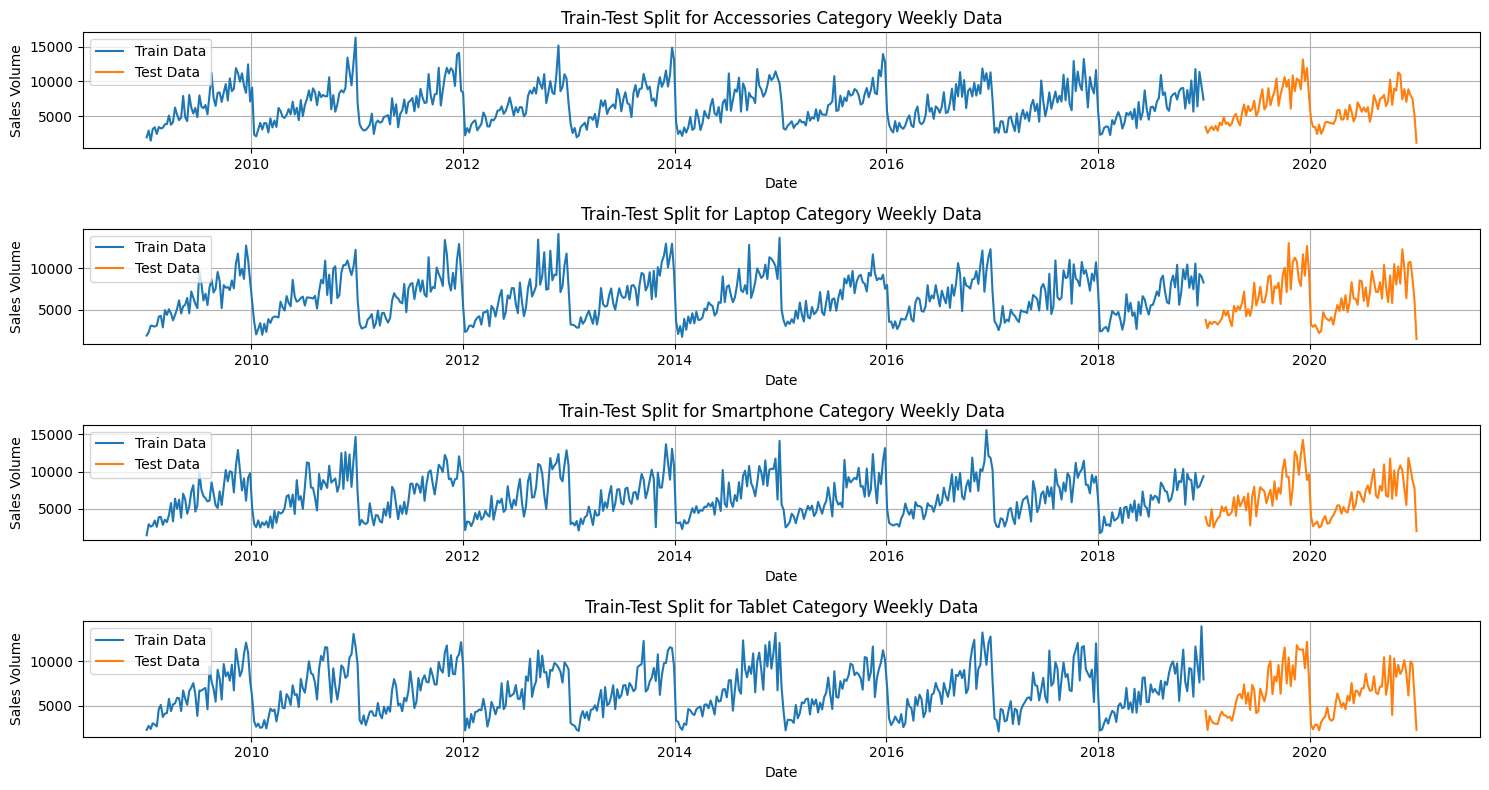

In [61]:
plt.figure(figsize=(15, 8))

num_categories = len(all_categories)

for i in range(len(all_categories)):
    category = all_categories[i]

    plt.subplot(num_categories, 1, i+1)
    # Plot train data
    plt.plot(weekly_sales_train_data[category]['ds'],
             weekly_sales_train_data[category]['y'])

    # Plot test data
    plt.plot(weekly_sales_test_data[category]['ds'],
             weekly_sales_test_data[category]['y'])
    
    plt.title(f'Train-Test Split for {category} Category Weekly Data')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend(['Train Data', 'Test Data'])
    plt.grid(True)

plt.tight_layout()
plt.show()

As seen,
- the blue color indicates our train dataset, which is all the sales data below 2019,
- the orange color indicates our test dataset, which is all the sales data in 2019 and 2020.

Next, the dataset for the each category is going to be fitted on the `Prophet` model. In order to do this, a few parameters are needed to obtain a model that can forecast well. These paramters will be inferred from what we know or what we can assume:
- `yearly_seasonality=True`: we will be setting the yearly seasonality value as `True` for the `Prophet` model because we saw some yearly patterns for the each category in the visualization above. One example of this pattern is the seeming spike in sales volume at the end of the year.
- `daily_seasonality=False`: this is being set to `False` because, there doesn't seem to be any apparent daily patterns in each category, and the data we are currently working with is a weekly data.

In [62]:
# Dictionary to store the models
prophet_weekly_models = dict()

for category in all_categories:

    # Initialize the Prophet model
    category_weekly_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False)

    # Train the model for each category
    category_weekly_prophet.fit(weekly_sales_train_data[category])

    # Store the model
    prophet_weekly_models[category] = category_weekly_prophet

09:36:26 - cmdstanpy - INFO - Chain [1] start processing
09:36:26 - cmdstanpy - INFO - Chain [1] done processing
09:36:27 - cmdstanpy - INFO - Chain [1] start processing
09:36:27 - cmdstanpy - INFO - Chain [1] done processing
09:36:28 - cmdstanpy - INFO - Chain [1] start processing
09:36:28 - cmdstanpy - INFO - Chain [1] done processing
09:36:29 - cmdstanpy - INFO - Chain [1] start processing
09:36:29 - cmdstanpy - INFO - Chain [1] done processing


Make forecasts for the test dataset for each category.

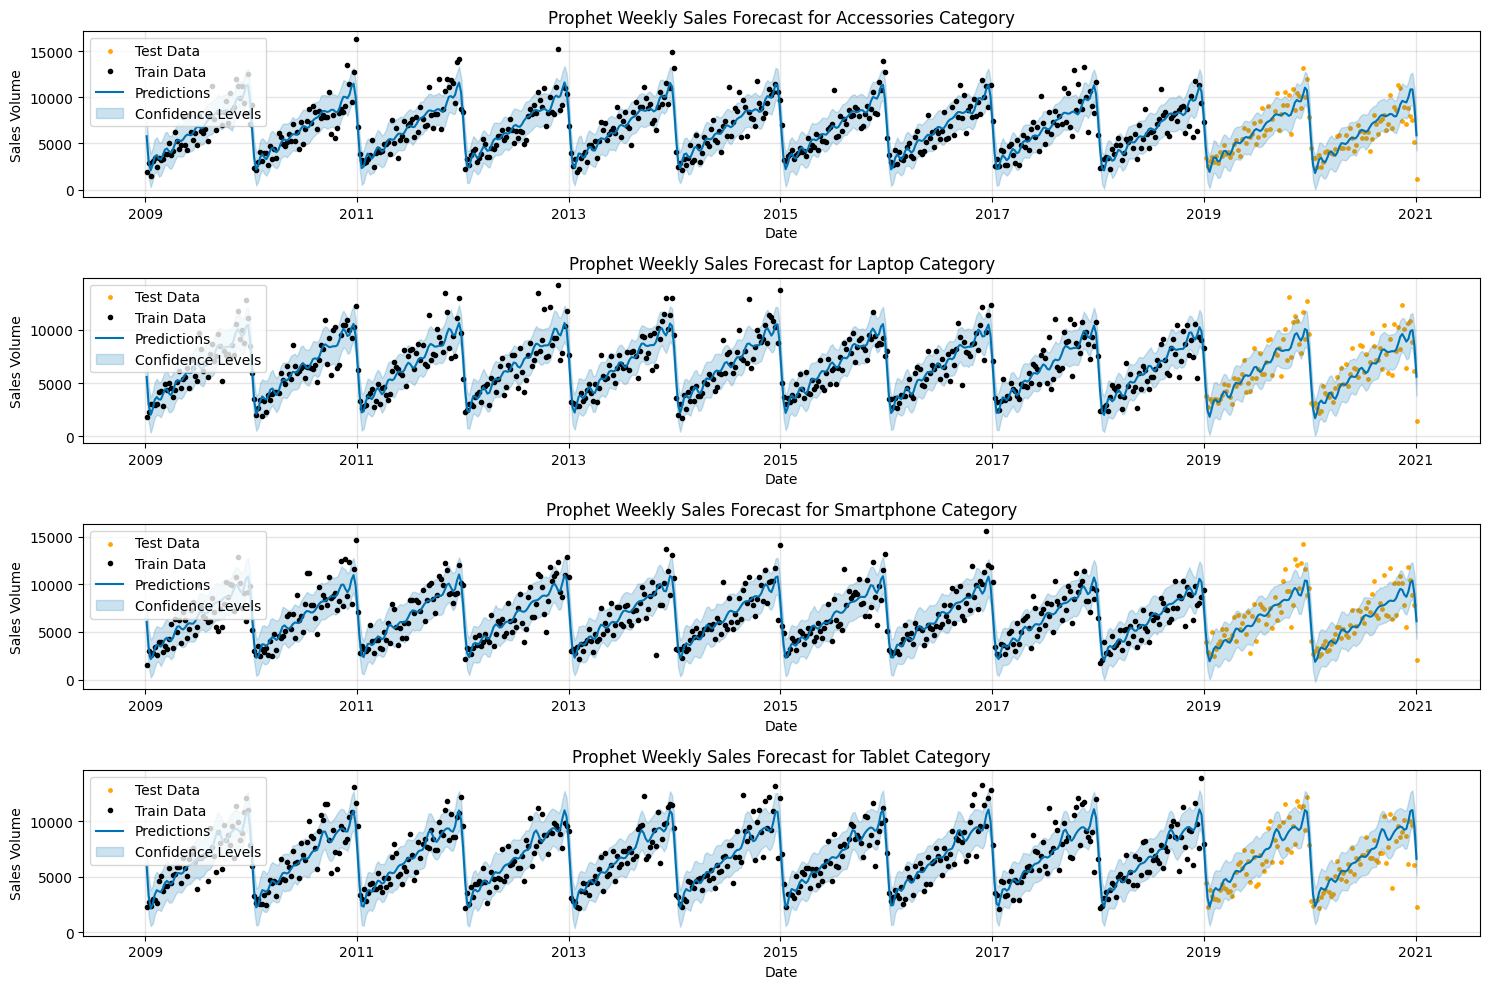

In [63]:
# Create dictionary to store the forecast for the test set
prophet_weekly_forecast = dict()

# Create subplots to plot all category forecasts
fig, ax = plt.subplots(len(all_categories), 
                       1, 
                       figsize=(15, 10))

for i in range(len(all_categories)):
    category = all_categories[i]

    # Get the number of periods in the test set for the category
    num_periods = len(weekly_sales_test_data[category])

    # Create the dates you want to make predictions for
    category_future_dates = prophet_weekly_models[category].make_future_dataframe(periods=num_periods, freq='W-MON')

    # Make predictions for those dates
    category_forecast = prophet_weekly_models[category].predict(category_future_dates)

    # Store forecast
    prophet_weekly_forecast[category] = category_forecast[-num_periods:]

    # Plot the test data
    ax[i].scatter(weekly_sales_test_data[category]['ds'], 
               weekly_sales_test_data[category]['y'], 
               color='orange', 
               s=6)
    
    # Plot the forecast
    category_plot = prophet_weekly_models[category].plot(category_forecast, 
                                                       ax=ax[i], 
                                                       figsize=(15, 7))

    ax[i].set_title(f'Prophet Weekly Sales Forecast for {category} Category')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Sales Volume')
    
    ax[i].legend(['Test Data', 'Train Data', 'Predictions', 'Confidence Levels'],
                 loc='upper left')

The plot above shows:
- **Black points**: the datapoints used for training the model,
- **Orange points**: the datapoints used for testing the model,
- **Blue line**: the forecast made by the Prophet model,
- **Light blue**: the confidence intervals by the Prophet model. These confidence intervals are the range of values its predictions are likely to fall within.

This model will be evaluated using three metrics on the test dataset:
- Mean Absolute Error (MAE),
- Root Mean Squared Error (RMSE), and
- Mean Absolue Percentage Error (MAPE)

In [64]:
mae, rmse, mape = 0, 0, 0

prophet_weekly_mape_scores = {}

for category in all_categories:

    # We only need the 'y' column from the `weekly_sales_test_data`
    test_data = weekly_sales_test_data[category]['y'].values

    # Get forecast data for the category, the category forecast contains
    # different columns in its output, we only need the 'yhat' column
    forecast_data = prophet_weekly_forecast[category]['yhat'].values

    # Calculate MAE
    category_mae = mean_absolute_error(test_data, forecast_data)

    # Calculate RMSE
    category_rmse = mean_squared_error(test_data, forecast_data, squared=False)

    # Calculate MAPE
    category_mape = np.mean(np.abs((test_data - forecast_data) / test_data)) * 100
    

    # Store calculated value
    mae += category_mae
    rmse += category_rmse
    mape += category_mape

    prophet_weekly_mape_scores[category] = category_mape

# Get the average value of each metric over all product categories
mae /= len(all_categories)
rmse /= len(all_categories)
mape /= len(all_categories)

# See the results
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

MAE: 1155.7112619940815
RMSE: 1479.8803655855702
MAPE: 20.701093796489282


A MAPE score of 20.79% is a pretty OK model for the weekly prediction with Prophet.

#### Forecasting monthly with Prophet model

We will be moving onto monthly forecasting for each of the product categories. We're going into monthly forecasting because, with monthly forecasts, we can easily aggregate sales, and the flunctuations that occur with weekly and daily data are lesser when aggregated monthly.

The `sales_by_date_category` dataset which contains the daily sales per category, will be grouped into months for each product category.

In [65]:
# Copy the `sales_by_date_category` data
sales_by_month_category = sales_by_date_category.copy()

# Set the Date column as the index
sales_by_month_category = sales_by_month_category.set_index('Date')

# Group the dataset by months and category, the Date Column becomes an index
sales_by_month_category = sales_by_month_category.groupby([pd.Grouper(freq='MS'), 'Category']).sum()

# Group the Date column back
sales_by_month_category = sales_by_month_category.reset_index()

sales_by_month_category.head(10)

,Date,Category,Sales_Volume
0,2009-01-01,Accessories,11762
1,2009-01-01,Laptop,11989
2,2009-01-01,Smartphone,12192
3,2009-01-01,Tablet,12491
4,2009-02-01,Accessories,12086
5,2009-02-01,Laptop,14507
6,2009-02-01,Smartphone,13563
7,2009-02-01,Tablet,16043
8,2009-03-01,Accessories,18578
9,2009-03-01,Laptop,20525


As can be seen, the dates now only increase by one month for each product category.

The dataset will be filtered for each category, split into train and test set, and then fitted on separate models for each category. The train set will contain all data before 2019, will the test set will contain all data from 2019.

In [66]:
# Create dictionaries to store train and test data for each category
monthly_sales_train_data = dict()
monthly_sales_test_data = dict()

for category in all_categories:

    # Get the dataset for each category
    category_data = sales_by_month_category[sales_by_month_category['Category'] == category][['Date', 'Sales_Volume']]

    # Rename columns to 'ds' and 'y', this is necessary for Prophet model
    category_data = category_data.rename(columns={'Date': 'ds', 'Sales_Volume': 'y'})

    # Store the train and test set
    monthly_sales_train_data[category] = category_data[category_data['ds'].dt.year < 2019]
    monthly_sales_test_data[category] = category_data[category_data['ds'].dt.year >= 2019]

Let's now visualize the train and test subsets for each of the product categories.

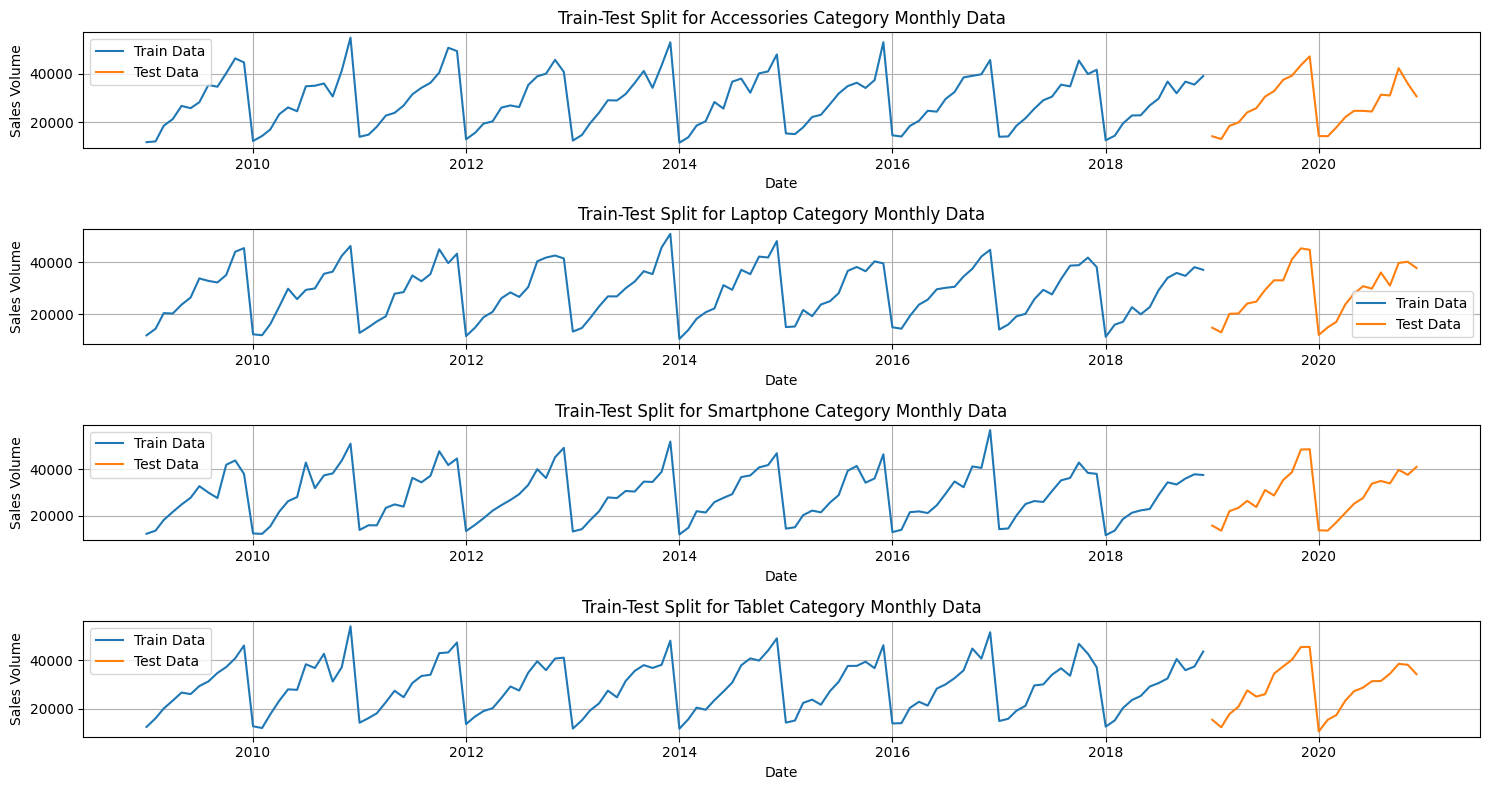

In [67]:
plt.figure(figsize=(15, 8))

num_categories = len(all_categories)

for i in range(len(all_categories)):
    category = all_categories[i]

    plt.subplot(num_categories, 1, i+1)
    # Plot train data
    plt.plot(monthly_sales_train_data[category]['ds'],
             monthly_sales_train_data[category]['y'])

    # Plot test data
    plt.plot(monthly_sales_test_data[category]['ds'],
             monthly_sales_test_data[category]['y'])
    
    plt.title(f'Train-Test Split for {category} Category Monthly Data')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend(['Train Data', 'Test Data'])
    plt.grid(True)

plt.tight_layout()
plt.show()

As seen,
- the blue color indicates our train dataset, which is all the sales data below 2019,
- the orange color indicates our test dataset, which is all the sales data in 2019 and 2020.

Next, the dataset for the each category is going to be fitted on the `Prophet` model. In order to do this, like before, a few parameters are needed to obtain a model that can forecast well. These paramters will be inferred from what we know or what we can assume:
- `yearly_seasonality=True`: we will be setting the yearly seasonality value as `True` for the `Prophet` model because we saw some yearly patterns for the each category in the visualization above. One example of this pattern is the seeming spike in sales volume at the end of the year.
- `daily_seasonality=False`: this is being set to `False` because, there doesn't seem to be any apparent daily patterns in each category, and the data we are currently working with is a monthly data.

In [68]:
# Dictionary to store the models
prophet_monthly_models = dict()

for category in all_categories:

    # Initialize the Prophet model
    category_monthly_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False)

    # Train the model for each category
    category_monthly_prophet.fit(monthly_sales_train_data[category])

    # Store the model
    prophet_monthly_models[category] = category_monthly_prophet

09:36:39 - cmdstanpy - INFO - Chain [1] start processing
09:36:39 - cmdstanpy - INFO - Chain [1] done processing
09:36:39 - cmdstanpy - INFO - Chain [1] start processing
09:36:39 - cmdstanpy - INFO - Chain [1] done processing
09:36:40 - cmdstanpy - INFO - Chain [1] start processing
09:36:40 - cmdstanpy - INFO - Chain [1] done processing
09:36:41 - cmdstanpy - INFO - Chain [1] start processing
09:36:41 - cmdstanpy - INFO - Chain [1] done processing


Make forecasts for the test dataset for each category.

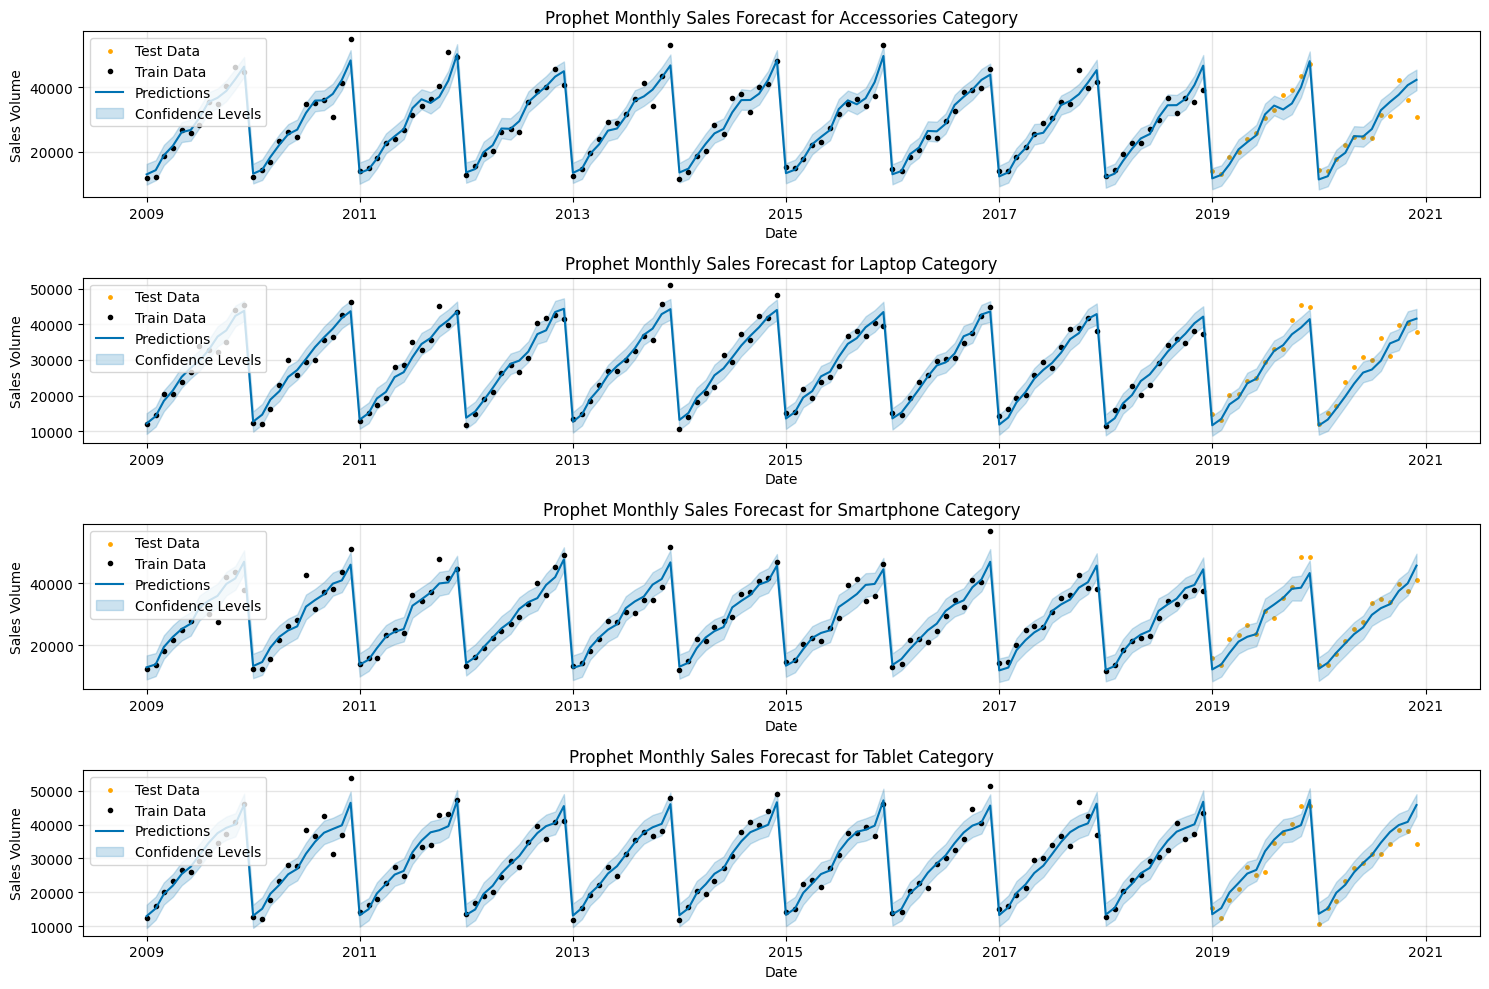

In [69]:
# Create dictionary to store the forecast for the test set
prophet_monthly_forecast = dict()

# Create subplots to plot all category forecasts
fig, ax = plt.subplots(len(all_categories), 
                       1, 
                       figsize=(15, 10))

for i in range(len(all_categories)):
    category = all_categories[i]

    # Get the number of periods in the test set for the category
    num_periods = len(monthly_sales_test_data[category])

    # Create the dates you want to make predictions for
    category_future_dates = prophet_monthly_models[category].make_future_dataframe(periods=num_periods, freq='MS')

    # Make predictions for those dates
    category_forecast = prophet_monthly_models[category].predict(category_future_dates)

    # Store forecast
    prophet_monthly_forecast[category] = category_forecast[-num_periods:]

    # Plot the test data
    ax[i].scatter(monthly_sales_test_data[category]['ds'], 
               monthly_sales_test_data[category]['y'], 
               color='orange', 
               s=6)
    
    # Plot the forecast
    category_plot = prophet_monthly_models[category].plot(category_forecast, 
                                                       ax=ax[i], 
                                                       figsize=(15, 7))

    ax[i].set_title(f'Prophet Monthly Sales Forecast for {category} Category')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Sales Volume')
    
    ax[i].legend(['Test Data', 'Train Data', 'Predictions', 'Confidence Levels'],
                 loc='upper left')

Again, the plot above shows:
- **Black points**: the datapoints used for training the model,
- **Orange points**: the datapoints used for testing the model,
- **Blue line**: the forecast made by the Prophet model,
- **Light blue**: the confidence intervals by the Prophet model. These confidence intervals are the range of values its predictions are likely to fall within.

This model will be evaluated using three metrics on the test dataset:
- Mean Absolute Error (MAE),
- Root Mean Squared Error (RMSE), and
- Mean Absolue Percentage Error (MAPE)

In [70]:
mae, rmse, mape = 0, 0, 0

prophet_monthly_mape_scores = {}

for category in all_categories:

    # We only need the 'y' column from the `monthly_sales_test_data`
    test_data = monthly_sales_test_data[category]['y'].values

    # Get forecast data for the category, the category forecast contains
    # different columns in its output, we only need the 'yhat' column
    forecast_data = prophet_monthly_forecast[category]['yhat'].values

    # Calculate MAE
    category_mae = mean_absolute_error(test_data, forecast_data)

    # Calculate RMSE
    category_rmse = mean_squared_error(test_data, forecast_data, squared=False)

    # Calculate MAPE
    category_mape = np.mean(np.abs((test_data - forecast_data) / test_data)) * 100
    

    # Store calculated value
    mae += category_mae
    rmse += category_rmse
    mape += category_mape

    prophet_monthly_mape_scores[category] = category_mape

# Get the average value of each metric over all product categories
mae /= len(all_categories)
rmse /= len(all_categories)
mape /= len(all_categories)

# See the results
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

MAE: 2497.412902318738
RMSE: 3363.116483873744
MAPE: 9.05399695142129


The MAPE for the monthly forecasting (9.05%), is way better than the MAPE gotten from the weekly forecasting (20.7%). This is because the lower the MAPE, the better the model.

#### Forecasting weekly with ARIMA model

ARIMA stands for AutoRegressive Integrated Moving Average, and we will be building a forecasting model for the laptop category with it.

Before one can build a model on ARIMA, it's necessary to check for stationarity in the dataset, as this is a requirement for using ARIMA. Stationarity here means that the statistical properties like mean and variance of the dataset do not change overtime.

To do this stationarity test, the Augmented Dickey-Fuller test will be used. We begin by defining a function to help us do this.

In [71]:
# Function to perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    dfoutput = pd.Series(result[0:4],index=['Test Statistic', # What we need
                                            'p-value', 
                                            '#lags used', # Number of lags used
                                            'number of observations used'])
    for key,value in result[4].items():
        dfoutput['critical value (%s)'%key]= value # What we're comparing against
    return dfoutput

Next we check for stationarity in each of the categories of the dataset. We already have a DataFrame that already contains grouped total sales by week called `sales_by_week_category`, we will be continuing with it.

In [72]:
# Review the DataFrame
sales_by_week_category.head(10)

,Date,Category,Sales_Volume
0,2009-01-05,Accessories,1933
1,2009-01-05,Laptop,1868
2,2009-01-05,Smartphone,1488
3,2009-01-05,Tablet,2283
4,2009-01-12,Accessories,2912
5,2009-01-12,Laptop,2273
6,2009-01-12,Smartphone,2959
7,2009-01-12,Tablet,2736
8,2009-01-19,Accessories,1459
9,2009-01-19,Laptop,3060


In [73]:
# Dictionary to store the weekly stationarity
weekly_stationarity = dict()

for category in all_categories:
    # Get the subset for the category
    category_data = sales_by_week_category[sales_by_week_category['Category'] == category]

    # Check stationarity for the category sales data
    category_stationarity = adf_test(category_data['Sales_Volume'])

    # Store the result
    weekly_stationarity[category] = category_stationarity.values
    
# Show results
pd.DataFrame(weekly_stationarity, index=category_stationarity.index)

,Accessories,Laptop,Smartphone,Tablet
Test Statistic,-6.717032e+00,-6.852744e+00,-7.039005e+00,-7.541596e+00
p-value,3.560491e-09,1.678042e-09,5.913282e-10,3.366819e-11
#lags used,2.000000e+00,7.000000e+00,2.000000e+00,1.900000e+01
number of observations used,6.240000e+02,6.190000e+02,6.240000e+02,6.070000e+02
critical value (1%),-3.440873e+00,-3.440958e+00,-3.440873e+00,-3.441169e+00
critical value (5%),-2.866183e+00,-2.866221e+00,-2.866183e+00,-2.866313e+00
critical value (10%),-2.569243e+00,-2.569263e+00,-2.569243e+00,-2.569312e+00


From the stationarity table, it can be seen that the "Test Statistic" for each category is less than all of the critical values of each respective categories shown. This indicates that the dataset is stationary.

We need two parameters to build our ARIMA model, they are the AR and MA paramters. To determine the AutoRegressive (AR) and Moving Average (MA) parameters for ARIMA, we need to display autocorrelation and partial autocorrelation plots to help choose the AR parameter for ARIMA.
- The auto-correlation (ACF) plot shows the correlation of a time series with a lagged version of itself. For example, if you have time series data at t = 0, 1, …, n, then taking the autocorrelation of data sets (0, 1), (1, 2) … (n − 1, n) apart would have a lag time of 1.
- The partial auto-correlation (PACF) plot shows the partial correlation coefficient between two observations in a time series.

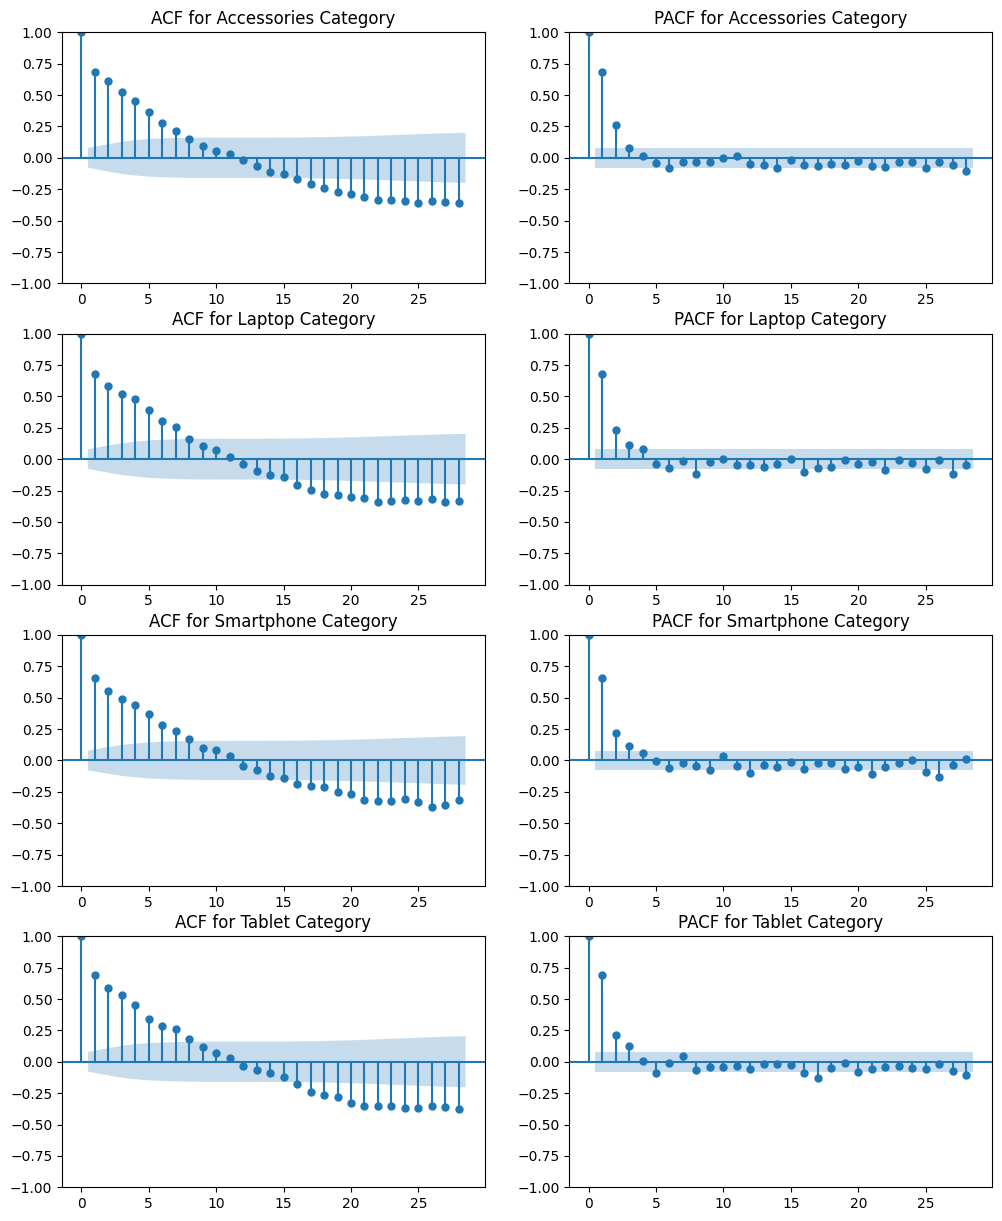

In [74]:
num_categories = len(all_categories)

fig, ax = plt.subplots(num_categories, 2, figsize=(12, 15))

for i in range(num_categories):
    category = all_categories[i]

    # Get the subset for the category
    category_data = sales_by_week_category[sales_by_week_category['Category'] == category]

    # Plot the ACF for that category
    acf_plot = plot_acf(category_data['Sales_Volume'], 
                        ax=ax[i][0],
                        title=f'ACF for {category} Category')

    # Plot the PACF for that category
    acf_plot = plot_pacf(category_data['Sales_Volume'], 
                         ax=ax[i][1],
                         title=f'PACF for {category} Category')
    
plt.show()

Three key things to note from these plots are:
- The ACF plots and PACF plots for all of the categories are almost identical.
- For the Autocorrelation (ACF) plot, the value touches the x axis at 11, the AR parameter is more difficult to pin point in this case, because it doesn't fluncuate around 0 anywhere. We'll just use a value of 1.
- For the Partial Autocorrelation (PACF) plot, the value flunctuates around 0, from 4 to the end, which means one of these values can be our MA parameter.

Before we fit the ARIMA model on the dataset, we will first reserve a test set for evaluation later.

The dataset will be filtered for each category, split into train and test set, and then fitted on separate models for each category. The train set will contain all data before 2019, will the test set will contain all data from 2019.

In [75]:
# Create dictionaries to store train and test data for each category
weekly_sales_train_data = dict()
weekly_sales_test_data = dict()

for category in all_categories:

    # Get the dataset for each category
    category_data = sales_by_week_category[sales_by_week_category['Category'] == category][['Date', 'Sales_Volume']]

    # Store the train and test set
    weekly_sales_train_data[category] = category_data[category_data['Date'].dt.year < 2019]
    weekly_sales_test_data[category] = category_data[category_data['Date'].dt.year >= 2019]

Fit the ARIMA model on the dataset.

In [76]:
# Dictionary to store the models
arima_weekly_models = dict()

for category in all_categories:

    # Initialize the ARIMA model
    category_model = ARIMA(weekly_sales_train_data[category]['Sales_Volume'].values, order=(5, 1, 0)) # MA = 5, AR = 1

    # Train the model for each category
    category_weekly_arima_model = category_model.fit()

    # Store the model
    arima_weekly_models[category] = category_weekly_arima_model

Forecast for 2019 and above.

In [77]:
# Dictionary to store the ARIMA weekly forecasts
arima_weekly_forecasts = dict()

for category in all_categories:
    # Get the size of the test set for that category
    num_steps = len(weekly_sales_test_data[category])

    # Forecast for that category
    category_forecast = arima_weekly_models[category].forecast(steps=num_steps)

    # Store the weekly forecast
    arima_weekly_forecasts[category] = category_forecast

Plot the actual and forecasted sales data.

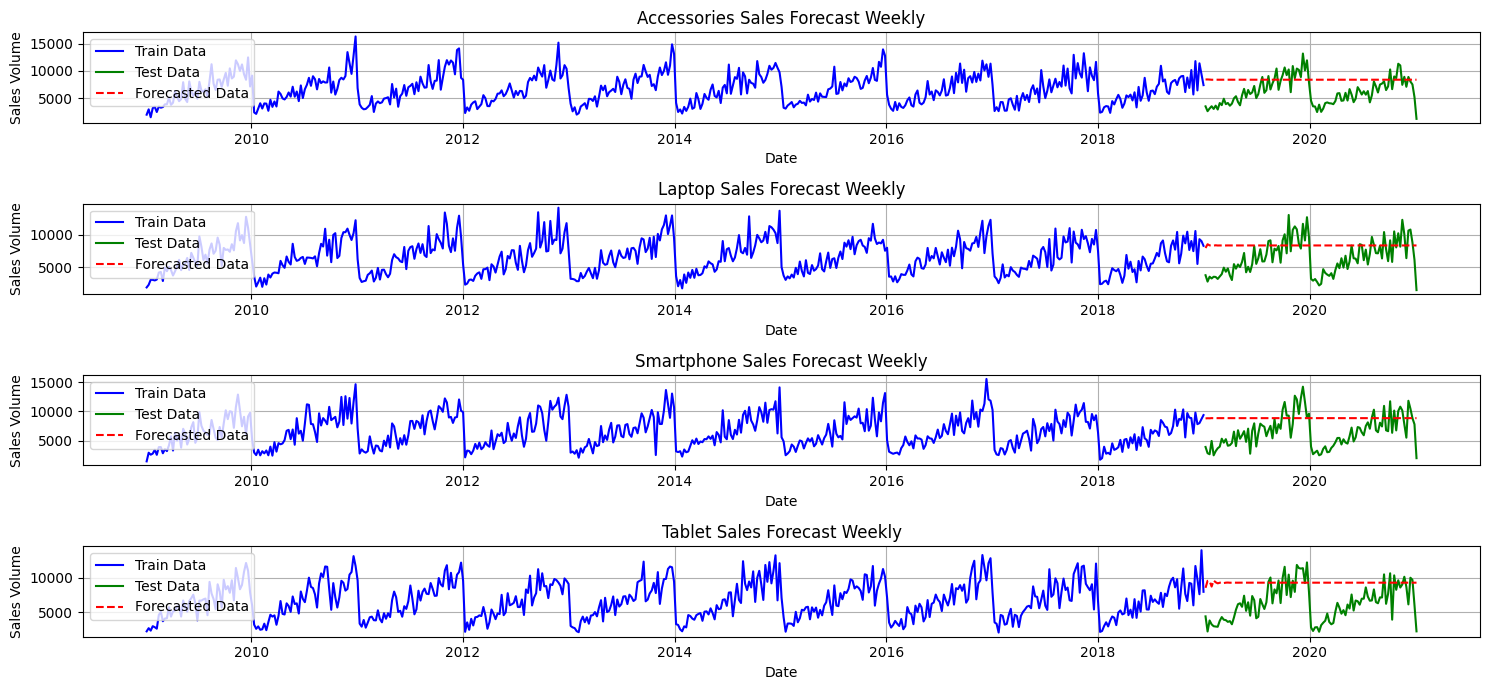

In [78]:
plt.figure(figsize=(15, 7))

# Get number of categories
num_categories = len(all_categories)

for i in range(num_categories):
    category = all_categories[i]

    plt.subplot(num_categories, 1, i+1)

    # Plot train data
    plt.plot(weekly_sales_train_data[category]['Date'], 
             weekly_sales_train_data[category]['Sales_Volume'], 
             label='Actual Sales (Train Data)',
             color='blue')

    # Plot test data
    plt.plot(weekly_sales_test_data[category]['Date'], 
             weekly_sales_test_data[category]['Sales_Volume'], 
             label='Actual Sales (Test Data)',
             color='green')
    
    # Plot the forecasted data
    plt.plot(weekly_sales_test_data[category]['Date'], 
             arima_weekly_forecasts[category], 
             label='Forecasted Sales', 
             color='red', 
             linestyle='--')
    
    plt.title(f'{category} Sales Forecast Weekly')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend(['Train Data', 'Test Data', 'Forecasted Data'])
    plt.grid(True)
    
plt.tight_layout()
plt.show()

This model will also be evaluated on the test set using three metrics:
- Mean Absolute Error (MAE),
- Root Mean Squared Error (RMSE), and
- Mean Absolue Percentage Error (MAPE)

In [79]:
mae, rmse, mape = 0, 0, 0

arima_weekly_mape_scores = {}

for category in all_categories:

    # Get the test data for the category
    test_data = weekly_sales_test_data[category]['Sales_Volume'].values

    # Get forecast data for the category
    forecast_data = arima_weekly_forecasts[category]

    # Calculate MAE
    category_mae = mean_absolute_error(test_data, forecast_data)

    # Calculate RMSE
    category_rmse = mean_squared_error(test_data, forecast_data, squared=False)

    # Calculate MAPE
    category_mape = np.mean(np.abs((test_data - forecast_data) / test_data)) * 100
    

    # Store calculated value
    mae += category_mae
    rmse += category_rmse
    mape += category_mape

    arima_weekly_mape_scores[category] = category_mape

# Get the average value of each metric over all product categories
mae /= len(all_categories)
rmse /= len(all_categories)
mape /= len(all_categories)

# See the results
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

MAE: 2938.3046908097012
RMSE: 3434.3787173496376
MAPE: 68.24614240731631


The Prophet model did better on the test set than this ARIMA model for weekly predictions. The Prophet model had a MAPE of 20.7%, while this ARIMA model had a MAPE of 68.2%. The lower the MAPE, the better the model.

### Forecasting monthly with ARIMA model

Here we will attempt to make monthly forecasts to see if the model gets better.

We already have a DataFrame with monthly sales volume aggregated for each category, called `sales_by_month_category`. We will continue working with this DataFrame.

In [80]:
sales_by_month_category.head(10)

,Date,Category,Sales_Volume
0,2009-01-01,Accessories,11762
1,2009-01-01,Laptop,11989
2,2009-01-01,Smartphone,12192
3,2009-01-01,Tablet,12491
4,2009-02-01,Accessories,12086
5,2009-02-01,Laptop,14507
6,2009-02-01,Smartphone,13563
7,2009-02-01,Tablet,16043
8,2009-03-01,Accessories,18578
9,2009-03-01,Laptop,20525


Split data into train and test sets, as usual, we will be using data from 2018 and below as the training data, and data from 2019 and above as the test data.

In [81]:
# Create dictionaries to store train and test data for each category
monthly_sales_train_data = dict()
monthly_sales_test_data = dict()

for category in all_categories:

    # Get the dataset for each category
    category_data = sales_by_month_category[sales_by_week_category['Category'] == category][['Date', 'Sales_Volume']]

    # Store the train and test set
    monthly_sales_train_data[category] = category_data[category_data['Date'].dt.year < 2019]
    monthly_sales_test_data[category] = category_data[category_data['Date'].dt.year >= 2019]

Train the model for each category.

In [82]:
# Dictionary to store the models
arima_monthly_models = dict()

for category in all_categories:

    # Initialize the ARIMA model. By experimentation we know that MA = 11, and AR = 1
    category_model = ARIMA(monthly_sales_train_data[category]['Sales_Volume'].values, order=(11, 1, 0)) # MA = 11, AR = 1

    # Train the model for each category
    category_monthly_arima_model = category_model.fit()

    # Store the model
    arima_monthly_models[category] = category_monthly_arima_model

Forecast for 2019 and above.

In [83]:
# Dictionary to store the ARIMA weekly forecasts
arima_monthly_forecasts = dict()

for category in all_categories:
    # Get the size of the test set for that category
    num_steps = len(monthly_sales_test_data[category])

    # Forecast for that category
    category_forecast = arima_monthly_models[category].forecast(steps=num_steps)

    # Store the monthly forecast
    arima_monthly_forecasts[category] = category_forecast

Plot the actual and forecasted monthly sales data for all categories.

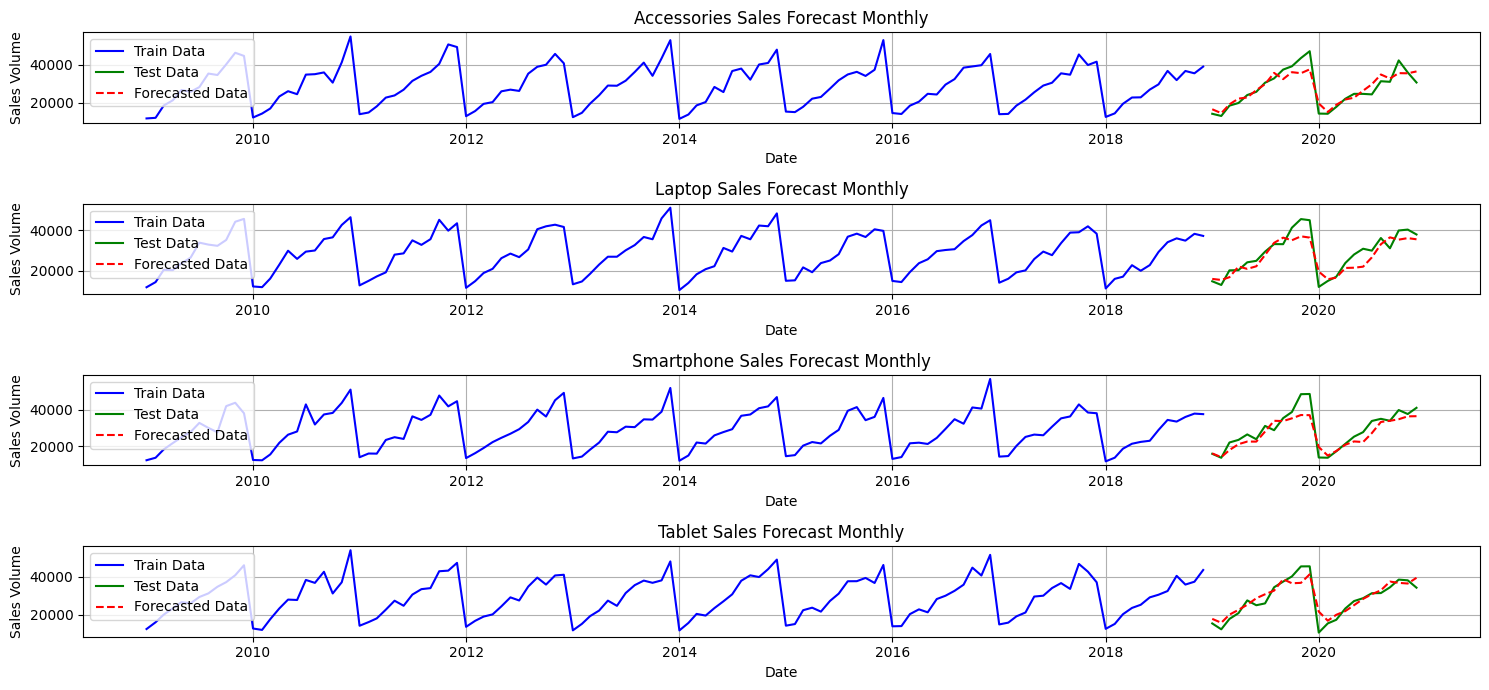

In [84]:
plt.figure(figsize=(15, 7))

# Get number of categories
num_categories = len(all_categories)

for i in range(num_categories):
    category = all_categories[i]

    plt.subplot(num_categories, 1, i+1)

    # Plot train data
    plt.plot(monthly_sales_train_data[category]['Date'], 
             monthly_sales_train_data[category]['Sales_Volume'], 
             label='Actual Sales (Train Data)',
             color='blue')

    # Plot test data
    plt.plot(monthly_sales_test_data[category]['Date'], 
             monthly_sales_test_data[category]['Sales_Volume'], 
             label='Actual Sales (Test Data)',
             color='green')
    
    # Plot the forecasted data
    plt.plot(monthly_sales_test_data[category]['Date'], 
             arima_monthly_forecasts[category], 
             label='Forecasted Sales', 
             color='red', 
             linestyle='--')
    
    plt.title(f'{category} Sales Forecast Monthly')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend(['Train Data', 'Test Data', 'Forecasted Data'])
    plt.grid(True)
    
plt.tight_layout()
plt.show()

Evaluating the model using the metrics on the test set:
- Mean Absolute Error (MAE),
- Root Mean Squared Error (RMSE), and
- Mean Absolue Percentage Error (MAPE)

In [85]:
mae, rmse, mape = 0, 0, 0

arima_monthly_mape_scores = {}

for category in all_categories:

    # Get the test data for the category
    test_data = monthly_sales_test_data[category]['Sales_Volume'].values

    # Get forecast data for the category
    forecast_data = arima_monthly_forecasts[category]

    # Calculate MAE
    category_mae = mean_absolute_error(test_data, forecast_data)

    # Calculate RMSE
    category_rmse = mean_squared_error(test_data, forecast_data, squared=False)

    # Calculate MAPE
    category_mape = np.mean(np.abs((test_data - forecast_data) / test_data)) * 100
    

    # Store calculated value
    mae += category_mae
    rmse += category_rmse
    mape += category_mape

    arima_monthly_mape_scores[category] = category_mape

# Get the average value of each metric over all product categories
mae /= len(all_categories)
rmse /= len(all_categories)
mape /= len(all_categories)

# See the results
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

MAE: 3357.1825216681727
RMSE: 4277.830165480827
MAPE: 12.704187451589995


Having a MAPE score of around 12.7% means that the model is doing pretty well at forecasting monthly sales for each product category. This is way better than the MAPE for ARIMA's weekly forecast  at 68.2%.

#### Forecasting weekly with Exponential Smoothing

In this approach, we will be building a forecasting model using the Holt-Winters method of Exponential Smoothing. And we will be doing this for all product categories in the dataset.

Before we begin we will still split the monthly Sales Volume dataset into train and test set, by training on all dataset that fall below 2019. We will then evaluate on the subset from 2019. We already have a DataFrame that contains the montly sales data for each category called `sales_by_week_category`, we will keep working with that.

In [86]:
# Create dictionaries to store train and test data for each category
weekly_sales_train_data = dict()
weekly_sales_test_data = dict()

for category in all_categories:

    # Get the dataset for each category
    category_data = sales_by_week_category[sales_by_week_category['Category'] == category][['Date', 'Sales_Volume']]

    # Store the train and test set
    weekly_sales_train_data[category] = category_data[category_data['Date'].dt.year < 2019]
    weekly_sales_test_data[category] = category_data[category_data['Date'].dt.year >= 2019]

Let's now build the model for each product category, and evaluate all at once.

In [87]:
# Store metrics
mae, rmse, mape = 0, 0, 0

hw_weekly_mape_scores = {}

# Store forecast results
hw_forecasts = dict()

for category in all_categories:

    # Build model for the category
    model = ExponentialSmoothing(weekly_sales_train_data[category]['Sales_Volume'], trend='add', seasonal='add', seasonal_periods=12)
    model_fit = model.fit()

    # Get number of steps
    num_steps = len(weekly_sales_test_data[category])

    # Forecast sales
    forecast_data = model_fit.forecast(steps=num_steps)
    hw_forecasts[category] = forecast_data

    # Get the test data for the category
    test_data = weekly_sales_test_data[category]['Sales_Volume'].values

    # Calculate MAE
    category_mae = mean_absolute_error(test_data, forecast_data)

    # Calculate RMSE
    category_rmse = mean_squared_error(test_data, forecast_data, squared=False)

    # Calculate MAPE
    category_mape = np.mean(np.abs((test_data - forecast_data) / test_data)) * 100
    

    # Store calculated value
    mae += category_mae
    rmse += category_rmse
    mape += category_mape

    hw_weekly_mape_scores[category] = category_mape

# Get the average value of each metric over all product categories
mae /= len(all_categories)
rmse /= len(all_categories)
mape /= len(all_categories)

# See the results
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

MAE: 6067.028896648006
RMSE: 6683.080121424909
MAPE: 126.79727886805887


As seen above the model performs pretty poorly for weekly predictions.

We will now go further by visualizing the forecasts and the actual sales volume.

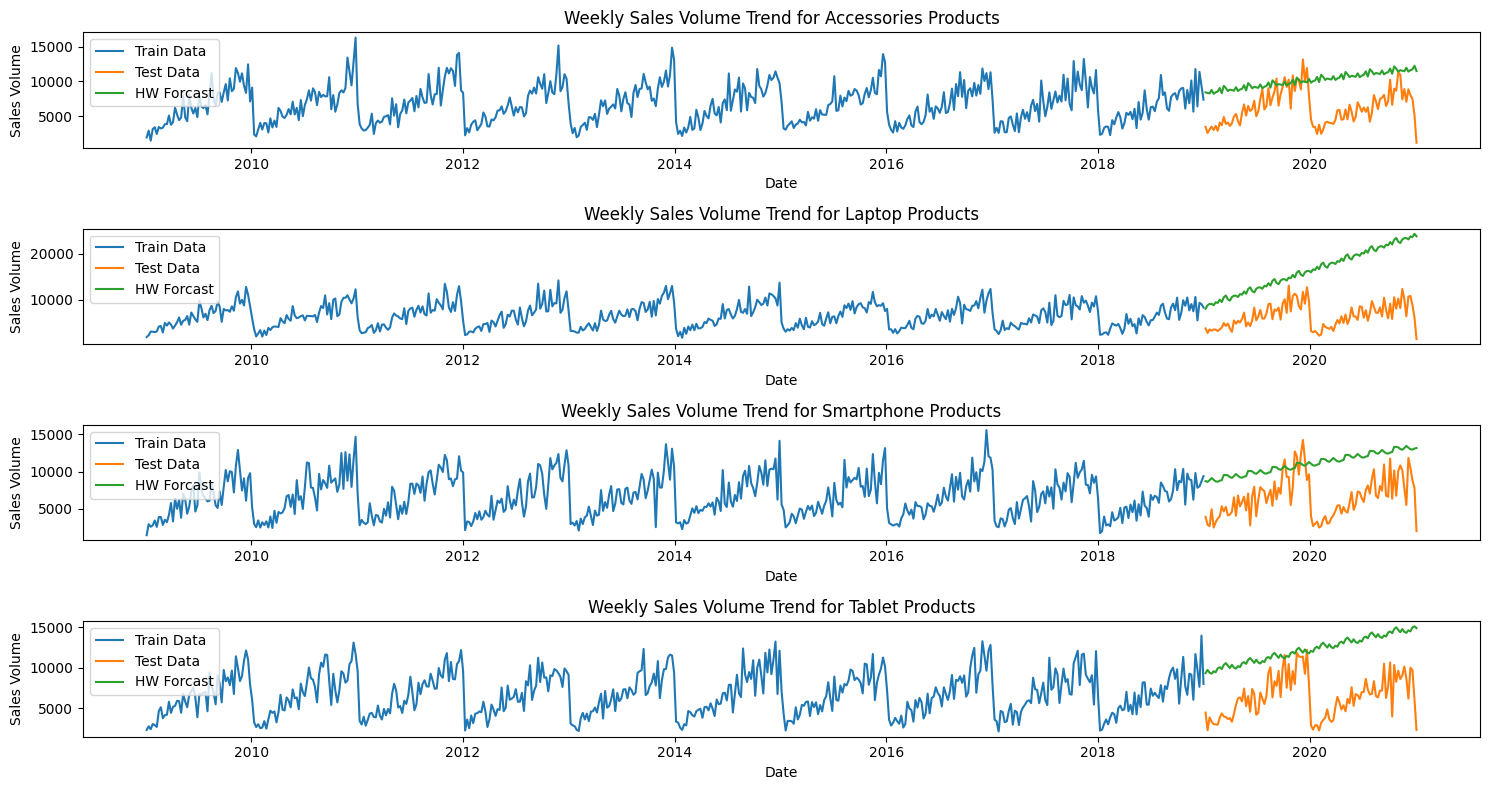

In [88]:
plt.figure(figsize=(15, 8))

i = 1
for category in all_categories:
    plt.subplot(4, 1, i)

    # Plot the train data
    plt.plot(weekly_sales_train_data[category]['Date'], 
             weekly_sales_train_data[category]['Sales_Volume'])
    
    # Plot the test data
    plt.plot(weekly_sales_test_data[category]['Date'], 
             weekly_sales_test_data[category]['Sales_Volume'])
    
    # Plot the forecasts
    plt.plot(weekly_sales_test_data[category]['Date'], 
             hw_forecasts[category])

    plt.title(f'Weekly Sales Volume Trend for {category} Products')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend(['Train Data', 'Test Data', 'HW Forcast'])

    i += 1

plt.tight_layout()
plt.show()

As seen the performance is really poor.

#### Forecasting monthly with Exponential Smoothing

In this approach, we will be building a forecasting model using the Holt-Winters method. And we will be doing this for all product categories in the dataset.

Before we begin we will still split the monthly Sales Volume dataset into train and test set, by training on all dataset that fall below 2019. We will then evaluate on the subset from 2019. We already have a DataFrame that contains the montly sales data for each category called `sales_by_month_category`, we will keep working with that.

In [89]:
# Create dictionaries to store train and test data for each category
monthly_sales_train_data = dict()
monthly_sales_test_data = dict()

for category in all_categories:

    # Get the dataset for each category
    category_data = sales_by_month_category[sales_by_month_category['Category'] == category][['Date', 'Sales_Volume']]

    # Store the train and test set
    monthly_sales_train_data[category] = category_data[category_data['Date'].dt.year < 2019]
    monthly_sales_test_data[category] = category_data[category_data['Date'].dt.year >= 2019]

Let's now build the model for each product category, and evaluate all at once.

In [90]:
# Store metrics
mae, rmse, mape = 0, 0, 0

hw_monthly_mape_scores = {}

# Store forecast results
hw_forecasts = dict()

for category in all_categories:

    # Build model for the category
    model = ExponentialSmoothing(monthly_sales_train_data[category]['Sales_Volume'], trend='add', seasonal='add', seasonal_periods=12)
    model_fit = model.fit()

    # Get number of steps
    num_steps = len(monthly_sales_test_data[category])

    # Forecast sales
    forecast_data = model_fit.forecast(steps=num_steps)
    hw_forecasts[category] = forecast_data

    # Get the test data for the category
    test_data = monthly_sales_test_data[category]['Sales_Volume'].values

    # Calculate MAE
    category_mae = mean_absolute_error(test_data, forecast_data)

    # Calculate RMSE
    category_rmse = mean_squared_error(test_data, forecast_data, squared=False)

    # Calculate MAPE
    category_mape = np.mean(np.abs((test_data - forecast_data) / test_data)) * 100
    

    # Store calculated value
    mae += category_mae
    rmse += category_rmse
    mape += category_mape

    hw_monthly_mape_scores[category] = category_mape

# Get the average value of each metric over all product categories
mae /= len(all_categories)
rmse /= len(all_categories)
mape /= len(all_categories)

# See the results
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

MAE: 2826.6103865068167
RMSE: 3662.467439574645
MAPE: 10.43476123763763


As seen above, this model performs better than anything we have tried before with a MAPE score of 10.4%. This is a pretty good model.

We will now go further by visualizing the forecasts and the actual sales volume.

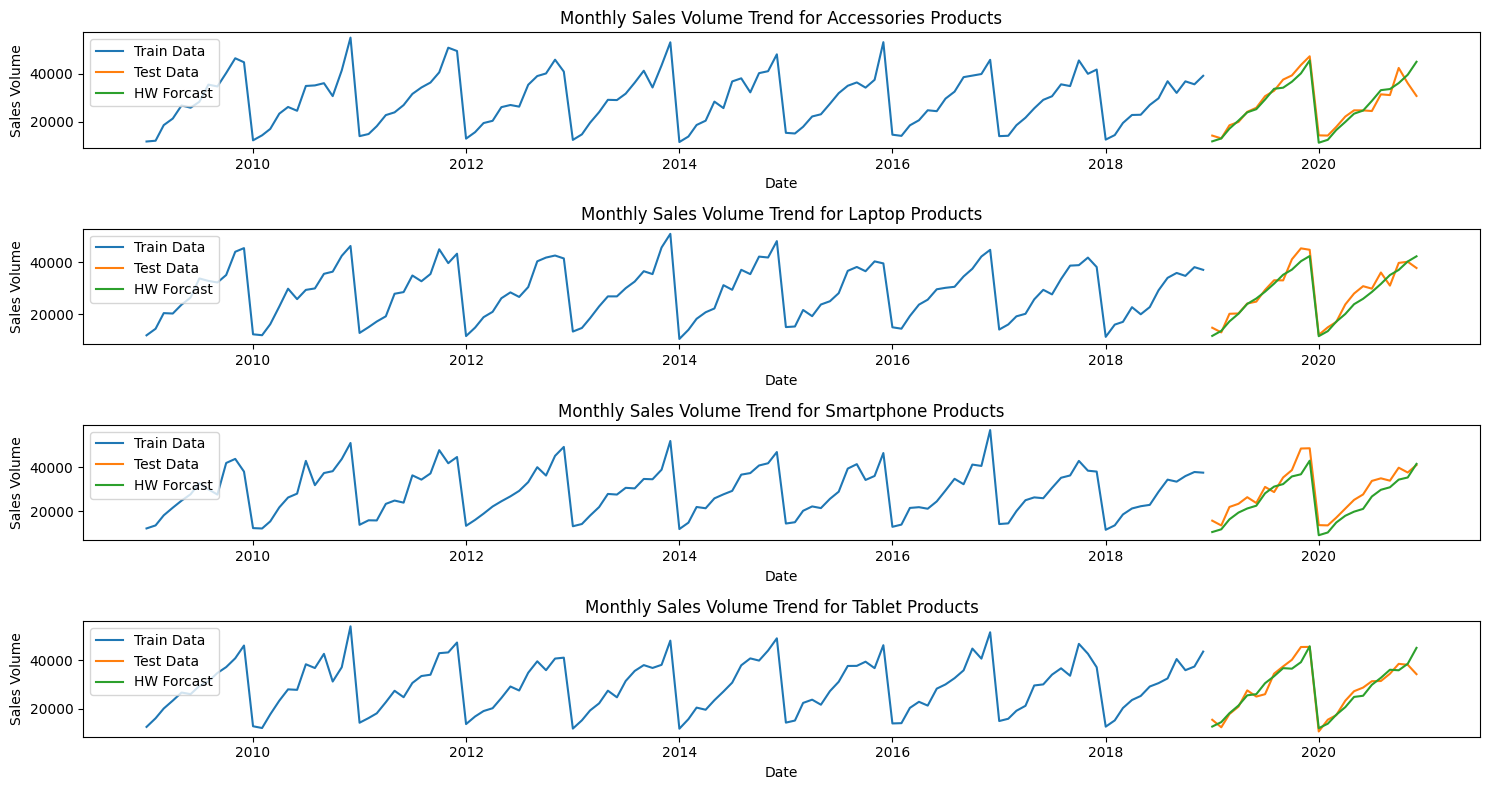

In [91]:
plt.figure(figsize=(15, 8))

i = 1
for category in all_categories:
    plt.subplot(4, 1, i)

    # Plot the train data
    plt.plot(monthly_sales_train_data[category]['Date'], 
             monthly_sales_train_data[category]['Sales_Volume'])
    
    # Plot the test data
    plt.plot(monthly_sales_test_data[category]['Date'], 
             monthly_sales_test_data[category]['Sales_Volume'])
    
    # Plot the forecasts
    plt.plot(monthly_sales_test_data[category]['Date'], 
             hw_forecasts[category])

    plt.title(f'Monthly Sales Volume Trend for {category} Products')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend(['Train Data', 'Test Data', 'HW Forcast'])

    i += 1

plt.tight_layout()
plt.show()

### Conclusion

In [92]:
# Get the evarage of each score
prophet_weekly_mape_scores['--Average--'] = np.mean([v for k, v in prophet_weekly_mape_scores.items()])
arima_weekly_mape_scores['--Average--'] = np.mean([v for k, v in arima_weekly_mape_scores.items()])
hw_weekly_mape_scores['--Average--'] = np.mean([v for k, v in hw_weekly_mape_scores.items()])
prophet_monthly_mape_scores['--Average--'] = np.mean([v for k, v in prophet_monthly_mape_scores.items()])
arima_monthly_mape_scores['--Average--'] = np.mean([v for k, v in arima_monthly_mape_scores.items()])
hw_monthly_mape_scores['--Average--'] = np.mean([v for k, v in hw_monthly_mape_scores.items()])

# MAPE scores for Prophet, ARIMA, and Exponential Smoothing
pd.DataFrame({'Prophet Weekly': prophet_weekly_mape_scores,
              'ARIMA Weekly': arima_weekly_mape_scores,
              'ES Weekly': hw_weekly_mape_scores,
              'Prophet Monthly': prophet_monthly_mape_scores,
              'ARIMA Monthly': arima_monthly_mape_scores,
              'ES Monthly': hw_monthly_mape_scores})

,Prophet Weekly,ARIMA Weekly,ES Weekly,Prophet Monthly,ARIMA Monthly,ES Monthly
Accessories,19.768000,65.479649,92.553644,9.146890,11.042051,9.331103
Laptop,19.679379,62.423617,191.810257,8.858850,14.253929,8.046522
Smartphone,20.914774,68.124910,99.037085,8.208040,11.605351,15.779316
Tablet,22.442222,76.956394,123.788128,10.002208,13.915419,8.582104
--Average--,20.701094,68.246142,126.797279,9.053997,12.704187,10.434761


Based on the work done here,
- monthly forecasting is more accurate than weekly forecasting for all models,
- of the three models (Prophet, ARIMA and Exponential Smoothing) tested here, Prophet Model had the best performance.